In [17]:
# Importing Python libraries
import  numpy as np
import cv2
import  matplotlib.pyplot as plt
import pandas as pd
from moviepy.editor import VideoFileClip

in this file we will understand entire process how our detector is working going in order as described by reference given

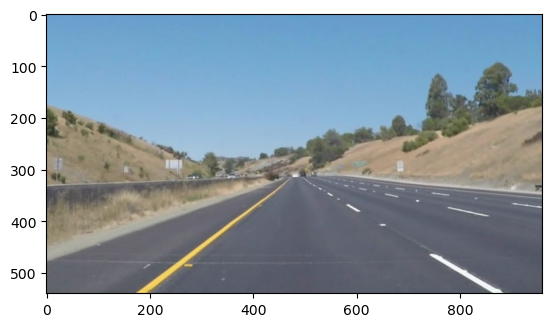

In [18]:
# reading a sample image
img = plt.imread("images/6.jpg")
plt.imshow(img)
plt.show()

# HSL color selection
here we will convert image from RGB format to HLS format, and lets view its different layers

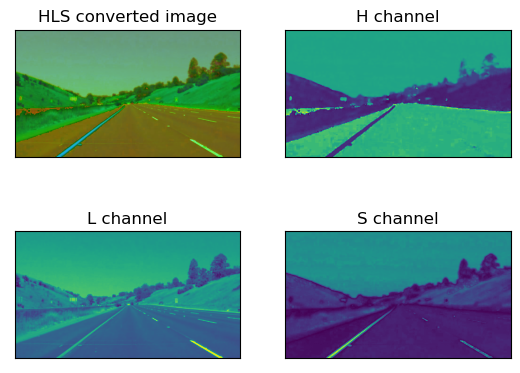

In [19]:
hsl_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

plt.subplot(2,2,1)
plt.imshow(hsl_image)
plt.xticks([])
plt.yticks([])
channels = ['H', 'L', 'S']
plt.title("HLS converted image")
for i in range(len(channels)):
    plt.subplot(2,2,i+2)
    plt.imshow(hsl_image[:,:,i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{channels[i]} channel")
plt.show()

here we can see white lines are clearly highlighted in L channel i.e. 3rd image yellow lines in H channel 2nd image so we will use these to create mask for our image

threshold values are basically range for detecting that color, they are picked from google

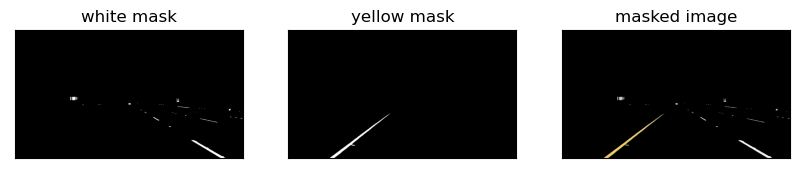

In [20]:
# White color mask
lower_threshold = np.uint8([0, 200, 0])
upper_threshold = np.uint8([255, 255, 255])
white_mask = cv2.inRange(hsl_image, lower_threshold, upper_threshold)

# Yellow color mask
lower_threshold = np.uint8([10, 0, 100])
upper_threshold = np.uint8([40, 255, 255])
yellow_mask = cv2.inRange(hsl_image, lower_threshold, upper_threshold)

#combining both the masks and applying it to original image
mask = cv2.bitwise_or(white_mask, yellow_mask)
masked_image = cv2.bitwise_and(img, img, mask=mask)

#plotting
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(white_mask, cmap='gray')
plt.title('white mask')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(yellow_mask, cmap='gray')
plt.title('yellow mask')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(masked_image)
plt.title('masked image')
plt.xticks([])
plt.yticks([])
plt.show()

# Edge detection
now we have obtained a mask, next we will convert image to grayscale, then apply gaussian blur this will help in detecting edges using canny edge detector

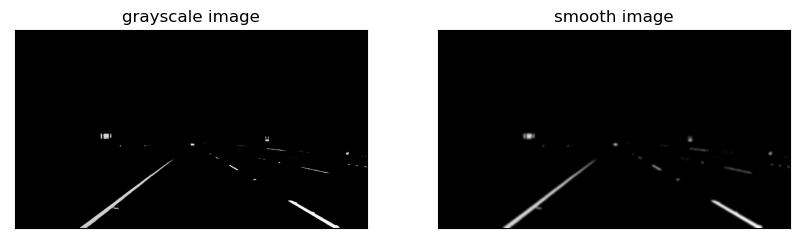

In [21]:
#convert to grayscale
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)

#apply gaussian blur
kernel_size = 13 # more the kernel size more will be blur amount
smooth = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

# plot images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title('grayscale image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(smooth, cmap='gray')
plt.title('smooth image')
plt.xticks([])
plt.yticks([])
plt.show()

now we will apply canny edge detector to these images

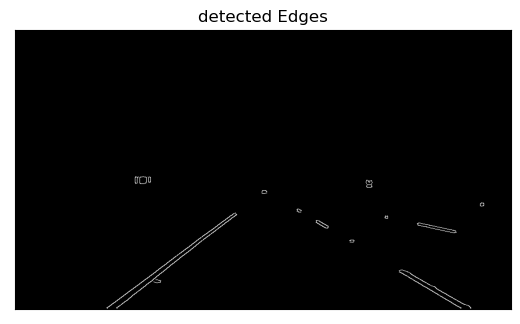

In [22]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(smooth, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')
plt.title('detected Edges')
plt.xticks([])
plt.yticks([])
plt.show()

# Region Selection
as we can see lanes are clearly detected but along with lanes some other stuffs like boards are also detected and to avoid them we will make a mask of trapezium shape to select only lanes which will be present inside it
![title](../masking.png)

In [23]:
mask = np.zeros_like(edges)
# Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
if len(edges.shape) > 2:
    channel_count = edges.shape[2]
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255

In [24]:
# making a rhombus for masking
rows, cols = edges.shape[:2]
bottom_left = [cols * 0.1, rows * 0.95]
top_left = [cols * 0.4, rows * 0.6]
bottom_right = [cols * 0.9, rows * 0.95]
top_right = [cols * 0.6, rows * 0.6]

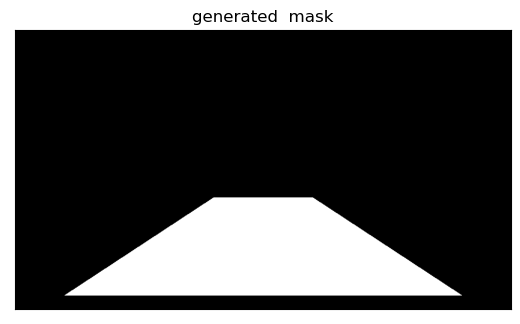

In [25]:
# making an array of points and making a mask using it
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)

#plotting mask
plt.imshow(mask, cmap='gray')
plt.title('generated  mask')
plt.xticks([])
plt.yticks([])
plt.show()

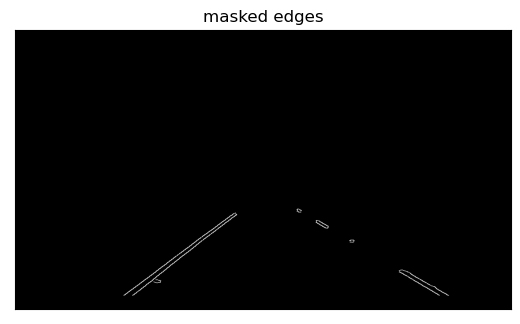

In [32]:
#applying generated mask on image
masked_image = cv2.bitwise_and(edges, mask)

#plotting
plt.imshow(masked_image, cmap='gray')
plt.title('masked edges')
plt.xticks([])
plt.yticks([])
plt.show()

# Hough Transformation
as now, we have obtained the lanes it's time to generate line from it for this we will use hough transformation

In [33]:
# used builtin houghLines function to get lines
lines = cv2.HoughLinesP(masked_image, rho=1, theta=np.pi / 180, threshold=20,
                            minLineLength=20, maxLineGap=300)

# visualize the points obtained for line, each line is shown by pair of 2 points
# pd.DataFrame(lines.reshape(13,4),columns=['x1', 'y1', 'x2', 'y2'])

ValueError: cannot reshape array of size 40 into shape (13,4)

now we have got all possible lines, next task in to identify them as left lane and right lane

In [36]:
left_lines = []  # (slope, intercept)
left_weights = []  # (length,)
right_lines = []  # (slope, intercept)
right_weights = []  # (length,)

for line in lines:
    for x1, y1, x2, y2 in line:
        # if line is vertical then ignore it as its slope will produce n/0
        if x1 == x2:
            continue

        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - (slope * x1)
        length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))

        #if slope is negative then append line to left lines else in right lines
        if slope < 0:
            left_lines.append((slope, intercept))
            left_weights.append(length)
        else:
            right_lines.append((slope, intercept))
            right_weights.append(length)

In [37]:
print("Left lines")
pd.DataFrame(left_lines, columns=["slope", 'intercept'])

Left lines


,slope,intercept
0,-0.751196,672.004785
1,-0.780000,690.840000
2,-0.748691,670.225131
3,-0.780488,689.634146
4,-0.750000,672.500000


In [38]:
print("Right lines")
pd.DataFrame(right_lines, columns=["slope", 'intercept'])

Right lines


,slope,intercept
0,0.575862,31.003448
1,0.601449,19.210145
2,0.575862,29.851724
3,0.599265,21.801471
4,0.577889,35.050251


now we have left and right lines seperated we can make a weighted average of them to finalize our lanes

In [39]:
left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None

now we have both left and right lanes, its time to draw them

In [17]:
# generating points to plot image, in frame of image

#left lane
y1 = img.shape[0]
y2 = y1 * 0.6
slope, intercept = left_lane
x1 = int((y1 - intercept) / slope)
x2 = int((y2 - intercept) / slope)
y1 = int(y1)
y2 = int(y2)
left_line = ((x1,y1), (x2,y2))

#right lane
y1 = img.shape[0]
y2 = y1 * 0.6
slope, intercept = right_lane
x1 = int((y1 - intercept) / slope)
x2 = int((y2 - intercept) / slope)
y1 = int(y1)
y2 = int(y2)
right_line = ((x1,y1), (x2,y2))

In [18]:
left_line

((182, 540), (465, 324))

In [19]:
right_line

((874, 540), (506, 324))

now we have points of detected lanes its time to plot them on image

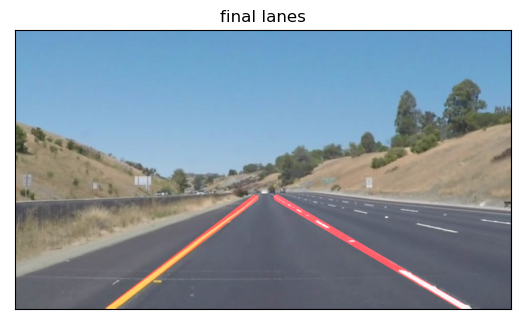

In [20]:
lines = (left_line,right_line)
line_image = np.zeros_like(img)
for line in lines:
    if line is not None:
        cv2.line(line_image, *line, [255,0,0], 12)
result = cv2.addWeighted(img, 1.0, line_image, 1.0, 0.0)

#plotting
plt.imshow(result)
plt.title('final lanes')
plt.xticks([])
plt.yticks([])
plt.show()

Lets use this on video file 